In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# You may need to restart the kernel after installing and seeing any kind of error. After restarting, try to install it again.
!pip install scikit-learn==0.22.2 --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install sklearn-crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.7 MB/s 


In [29]:
import pandas as pd
import numpy as np
from pprint import pprint
import joblib
#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#Modeling
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.externals import joblib
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

In [5]:
# Loading data
data = pd.read_csv('/content/drive/MyDrive/conll2003.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,EU,NNP,B-ORG
1,NaN,rejects,VBZ,O
2,NaN,German,JJ,B-MISC
3,NaN,call,NN,O
4,NaN,to,TO,O


In [6]:
# Data inspection
print('The number of all words:', len(data['Word']))
print('The number of all unique words:', len(data['Word'].unique()))
print('The number of all unique tags:', len(data['Tag'].unique()))
print('The distribution of tags: \n', data['Tag'].value_counts())

The number of all words: 301418
The number of all unique words: 30289
The number of all unique tags: 9
The distribution of tags: 
 O         250660
B-LOC      10645
B-PER      10059
B-ORG       9323
I-PER       6991
I-ORG       5290
B-MISC      5062
I-MISC      1717
I-LOC       1671
Name: Tag, dtype: int64


In [7]:
# Getting data ready
class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [8]:
data_fillna = data.fillna(method='ffill', axis=0)
getter = getsentence(data_fillna)
sentences = getter.sentences

In [9]:
print('The number of sentences:', len(sentences),'\n')
print('This is how a sentence will look like:\n', sentences[0])

The number of sentences: 14041 

This is how a sentence will look like:
 [('EU', 'NNP', 'B-ORG'), ('rejects', 'VBZ', 'O'), ('German', 'JJ', 'B-MISC'), ('call', 'NN', 'O'), ('to', 'TO', 'O'), ('boycott', 'VB', 'O'), ('British', 'JJ', 'B-MISC'), ('lamb', 'NN', 'O'), ('.', '.', 'O'), ('CRICKET', 'NNP', 'O'), ('-', ':', 'O'), ('LEICESTERSHIRE', 'NNP', 'B-ORG'), ('TAKE', 'NNP', 'O'), ('OVER', 'IN', 'O'), ('AT', 'NNP', 'O'), ('TOP', 'NNP', 'O'), ('AFTER', 'NNP', 'O'), ('INNINGS', 'NNP', 'O'), ('VICTORY', 'NN', 'O'), ('.', '.', 'O'), ('SOCCER', 'NN', 'O'), ('-', ':', 'O'), ('JAPAN', 'NNP', 'B-LOC'), ('GET', 'VB', 'O'), ('LUCKY', 'NNP', 'O'), ('WIN', 'NNP', 'O'), (',', ',', 'O'), ('CHINA', 'NNP', 'B-PER'), ('IN', 'IN', 'O'), ('SURPRISE', 'DT', 'O'), ('DEFEAT', 'NN', 'O'), ('.', '.', 'O')]


In [10]:
#Lets find the number of words in the dataset
words = list(set(data["Word"].values))
n_words = len(words)
print(n_words)

30289


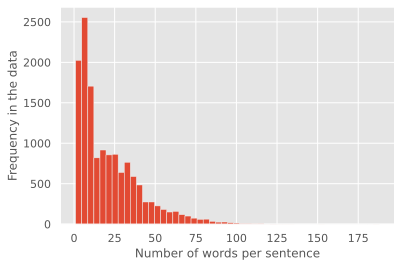

In [11]:
#Lets visualize how the data are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('Number of words per sentence')
plt.ylabel('Frequency in the data')
plt.show()

In [12]:
#Lets find out the longest sentence length in the dataset
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

Maximum sentence length: 188


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


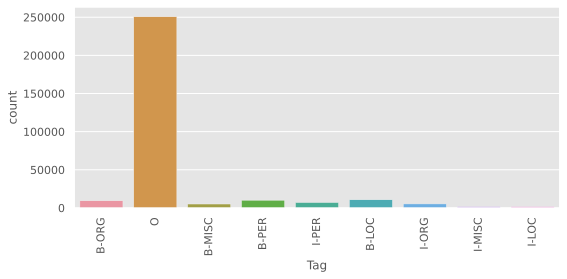

In [13]:
#Words distribution across Tags
plt.figure(figsize=(8, 4))
ax = sns.countplot('Tag', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


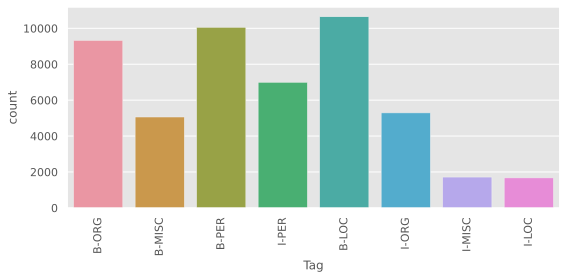

In [14]:
#Words distribution across Tags without O tag
plt.figure(figsize=(8, 4))
ax = sns.countplot('Tag', data=data.loc[data['Tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


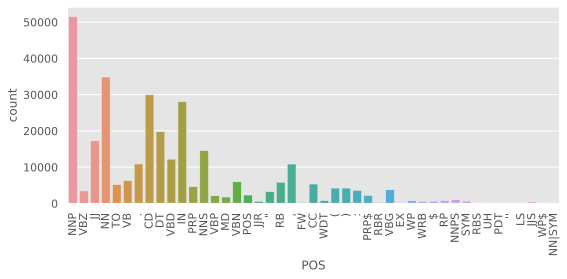

In [15]:
#Words distribution across POS
plt.figure(figsize=(8, 4))
ax = sns.countplot('POS', data=data, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [16]:
# Feature set
# we are adding more features to each word

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [17]:
#Creating the features and labels set
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [38]:
# this is how a sentence will look like after feature selection
pprint(X[100])

[{'+1:postag': ',',
  '+1:postag[:2]': ',',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:word.lower()': ',',
  'BOS': True,
  'bias': 1.0,
  'postag': 'NNP',
  'postag[:2]': 'NN',
  'word.isdigit()': False,
  'word.istitle()': False,
  'word.isupper()': True,
  'word.lower()': 'manchester',
  'word[-2:]': 'ER',
  'word[-3:]': 'TER'},
 {'+1:postag': 'NNP',
  '+1:postag[:2]': 'NN',
  '+1:word.istitle()': True,
  '+1:word.isupper()': False,
  '+1:word.lower()': 'england',
  '-1:postag': 'NNP',
  '-1:postag[:2]': 'NN',
  '-1:word.istitle()': False,
  '-1:word.isupper()': True,
  '-1:word.lower()': 'manchester',
  'bias': 1.0,
  'postag': ',',
  'postag[:2]': ',',
  'word.isdigit()': False,
  'word.istitle()': False,
  'word.isupper()': False,
  'word.lower()': ',',
  'word[-2:]': ',',
  'word[-3:]': ','},
 {'+1:postag': 'CD',
  '+1:postag[:2]': 'CD',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:word.lower()': '1996-08-28',
  '-1:postag': ',',
  '-1

In [39]:
# this is how a word will look like after feature selection
pprint(X[100][0])

{'+1:postag': ',',
 '+1:postag[:2]': ',',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:word.lower()': ',',
 'BOS': True,
 'bias': 1.0,
 'postag': 'NNP',
 'postag[:2]': 'NN',
 'word.isdigit()': False,
 'word.istitle()': False,
 'word.isupper()': True,
 'word.lower()': 'manchester',
 'word[-2:]': 'ER',
 'word[-3:]': 'TER'}


In [40]:
# Splitting data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [41]:
print('Number of sentences in train:', len(X_train))
print('Number of labels in train:', len(y_train), '\n')
print('Number of sentences in test:', len(X_test))
print('Number of labels in test:', len(y_test))

Number of sentences in train: 12636
Number of labels in train: 12636 

Number of sentences in test: 1405
Number of labels in test: 1405


In [42]:
# First we select all the tags that are relevant for us i.e. remove the 'O' tag from the list. 
labels = list(data_fillna['Tag'].unique())
labels_no_O = list(data_fillna['Tag'].unique())
labels_no_O.remove('O')
print('Number of tags in total:', len(labels))
print('Number of tags without tag "O":', len(labels_no_O))

Number of tags in total: 9
Number of tags without tag "O": 8


In [ ]:
# Now we will create the Randomized CV search model wherein we will use a modified F1 scorer model considering only the relevant labels
# define fixed parameters and parameters to search
crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=5,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/root/.local/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  8.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_...
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f12b7471550>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f12b74714c0>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,


In [ ]:
# Saving the best estimator
joblib.dump(rs.best_estimator_, '/content/drive/MyDrive/rs_bestmodel_conll2003.pkl')

['/content/drive/MyDrive/rs_bestmodel_conll2003.pkl']

In [ ]:
#saving the the whole trained model
joblib.dump(rs, '/content/drive/MyDrive/rs_object2_conll2003.pkl')

['/content/drive/MyDrive/rs_object2_conll2003.pkl']

In [43]:
#load the model
model = joblib.load('/content/drive/MyDrive/rs_object2_conll2003.pkl')

In [44]:
#Lets check the best estimated parameters and CV score
print('Best parameters:', model.best_params_)
print('Best CV score:', model.best_score_)
print('Model size: {:0.2f}M'.format(model.best_estimator_.size_ / 1000000))

Best parameters: {'c1': 0.04932394425371167, 'c2': 0.026592871390540285}
Best CV score: 0.9794565646035706
Model size: 1.88M


In [45]:
#We sort the tags a bit so that they appear in an orderly fashion in the classification report
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0]))
sorted_labels_no_O = sorted(
    labels_no_O,
    key=lambda name: (name[1:], name[0]))

In [46]:
# Check the best estimator on train data
crf = model.best_estimator_
y_pred = crf.predict(X_train)

In [47]:
# Results with considering tag "O"
print(metrics.flat_classification_report(y_train, y_pred, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

           O      1.000     1.000     1.000    225759
       B-LOC      0.996     0.997     0.996      9604
       I-LOC      0.995     0.999     0.997      1507
      B-MISC      0.998     0.995     0.997      4560
      I-MISC      0.995     0.995     0.995      1540
       B-ORG      0.995     0.996     0.996      8404
       I-ORG      0.999     0.997     0.998      4726
       B-PER      1.000     0.999     0.999      9005
       I-PER      1.000     1.000     1.000      6259

    accuracy                          0.999    271364
   macro avg      0.997     0.997     0.997    271364
weighted avg      0.999     0.999     0.999    271364



In [48]:
# Results with NOT considering tag "O"
print(metrics.flat_classification_report(y_train, y_pred, labels=sorted_labels_no_O, digits=3))

              precision    recall  f1-score   support

       B-LOC      0.996     0.997     0.996      9604
       I-LOC      0.995     0.999     0.997      1507
      B-MISC      0.998     0.995     0.997      4560
      I-MISC      0.995     0.995     0.995      1540
       B-ORG      0.995     0.996     0.996      8404
       I-ORG      0.999     0.997     0.998      4726
       B-PER      1.000     0.999     0.999      9005
       I-PER      1.000     1.000     1.000      6259

   micro avg      0.998     0.997     0.997     45605
   macro avg      0.997     0.997     0.997     45605
weighted avg      0.998     0.997     0.997     45605



In [49]:
# Now we predict on test data with the best estimator
y_pred = crf.predict(X_test)

In [50]:
# Results with considering tag "O"
print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

           O      0.993     0.997     0.995     24901
       B-LOC      0.951     0.939     0.945      1041
       I-LOC      0.928     0.860     0.892       164
      B-MISC      0.939     0.859     0.897       502
      I-MISC      0.907     0.774     0.835       177
       B-ORG      0.906     0.896     0.901       919
       I-ORG      0.891     0.865     0.878       564
       B-PER      0.940     0.950     0.945      1054
       I-PER      0.947     0.970     0.958       732

    accuracy                          0.983     30054
   macro avg      0.934     0.901     0.916     30054
weighted avg      0.983     0.983     0.983     30054



In [51]:
# Results with NOT considering tag "O"
print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels_no_O, digits=3))

              precision    recall  f1-score   support

       B-LOC      0.951     0.939     0.945      1041
       I-LOC      0.928     0.860     0.892       164
      B-MISC      0.939     0.859     0.897       502
      I-MISC      0.907     0.774     0.835       177
       B-ORG      0.906     0.896     0.901       919
       I-ORG      0.891     0.865     0.878       564
       B-PER      0.940     0.950     0.945      1054
       I-PER      0.947     0.970     0.958       732

   micro avg      0.930     0.914     0.922      5153
   macro avg      0.926     0.889     0.906      5153
weighted avg      0.930     0.914     0.921      5153

